## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import recall_score
%matplotlib inline
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import imblearn

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def coordinates(item, start=0):
    try:
        k = item.find('coordinates":')
        s = item.find('}')
        coordinate = item[k+13:s].replace(':','').replace('}','').replace('[','').replace(']','').split(',')
        coordinate = list(map(lambda x: float(x), coordinate))
        coordinates1=[]


        for n in range(start,len(coordinate),2):
            coordinates1.append(coordinate[n])

    except:
        coordinates1 = 0

    
    return coordinates1

In [3]:
def add_data(df):
    df = df.reindex(sorted(df.columns), axis=1)
    df['.long'] = df['.geo'].map(lambda x: np.mean(coordinates(x,0)))
    df['.latit'] = df['.geo'].map(lambda x: np.mean(coordinates(x,1)))
    #df['.dist'] = [np.sqrt((row[0]-30)**2+(row[1]-49)**2) for row in df[['.long','.latit']].to_numpy()]
    #df['.angle'] = [np.arctanh((row[0]-49)/(row[1]-30)) for row in df[['.long','.latit']].to_numpy()]
    df = df.reindex(sorted(df.columns), axis=1)
    return df

In [4]:
def add_cumulative(df):
    df = df.reindex(sorted(df.columns), axis=1)
    
    s=list(df.columns).index('nd_mean_2021-04-15')
    ss = len(df.columns)
    #print(s)
    df['.start'] = 0
    name = '.start'
    for column in df.columns[s:ss]: # add crop removal
   
        new_col = 'xcum_'+column
        #print(new_col)
        df[new_col] = df[name]+df[column]
        name = new_col
    df=df.drop('.start', axis = 1)
    df = df.reindex(sorted(df.columns), axis=1)
    return df

In [5]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [6]:
def filter_0 (d):
    d = d.reindex(sorted(d.columns), axis=1)
    s=list(d.columns).index('nd_mean_2021-04-15')+1 
    print(s)
    x,y = np.where(d.iloc[:,s:-1]==0.)
    for i in tqdm(range(len(x))):#
        f=d.iloc[x[i],y[i]+s-1]
        g=d.iloc[x[i],y[i]+s+1]
        z=(f+g)/2.
        d.iloc[x[i],y[i]+s] = z

    return d

In [7]:
def normalize (d):
    d = d.reindex(sorted(d.columns), axis=1)
    s=list(d.columns).index('nd_mean_2021-04-15')
    ss = list(d.columns).index('nd_mean_2021-08-27')+1
    print(s)
    max = d.iloc[:,s:ss+1].max(axis = 1)
    d.iloc[:,s:ss+1] = d.iloc[:,s:ss+1].div(max, axis=0)


    return d

In [8]:
def filter_0_nan (df):
    df = df.reindex(sorted(df.columns), axis=1)
    s=list(df.columns).index('nd_mean_2021-04-15')+1 
    print(s)
    df.iloc[:,s:] = np.where(df.iloc[:,s:]==0., np.nan, df.iloc[:,s:])
    
    return df

In [483]:
#finding difficult stuff
def diff_samples_add(df):
    X = df.drop(['id','.geo',"crop"], axis = 1)#"id",, '.long_full', '.latit_full', '7', 'index'
    y = df[["crop"]]
    
    kf = KFold(n_splits=4, shuffle=True)
    kf.get_n_splits(X)
    ind = []
    models = []

    #predict = np.zeros((len(y), 7))
    for train_index, test_index in kf.split(X):
    
        X_tr, X_te = X.iloc[train_index], X.iloc[test_index]
        y_tr, y_te = y.iloc[train_index], y.iloc[test_index]
        #clf1 = HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=30, l2_regularization = 0.5, learning_rate = 0.1).fit(X_tr, y_tr)#clf1 = HistGradientBoostingClassifier(max_iter=200, max_leaf_nodes=41).fit(X_tr, y_tr)
        clf1 = HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=41).fit(X_tr, y_tr)
        models.append(clf1)
        #predict += clf1.predict_proba(X_test)
        pred = clf1.predict(X_te)
        print(clf1,'\n',recall_score(y_te, pred, average=None, zero_division=0))
        ind.append(y_te[y_te.crop!=pred].index)
    idx = [item for sublist in ind for item in sublist]
    return models, idx


In [482]:
def running_sum(df, window = 3):
    df = df.reindex(sorted(df.columns), axis=1)
    window = window
    s=list(df.columns).index('nd_mean_2021-04-15')+2
    ss = list(df.columns).index('nd_mean_2021-08-27')+1
    print(s)
    columns = list(map(lambda x: 'run_'+x, df.columns[s:ss]))
    df.loc[:,columns] = np.nan_to_num(df.iloc[:,s:ss].rolling(window, center=True,axis=1)
                                    .sum())#.iloc[row,:]
    return df

In [11]:
def intersect(long1,long2,lat1,lat2):
    x1,x2 = long1
    x3,x4 = long2
    y1,y2 = lat1
    y3,y4 = lat2
    if (x2>=x3 and y2>=y3):
        
        intersect = np.sqrt((x3-x2)**2 + (y2-y3)**2)
        #print(intersect)
    else:
        intersect = 0
    return intersect
        
    

In [12]:
def remove_neg(df):
    df = df.reindex(sorted(df.columns), axis=1)
    s=list(df.columns).index('nd_mean_2021-04-15')
    ss = list(df.columns).index('nd_mean_2021-08-27')
    neg = np.where(df.iloc[:, s:ss+1] < 0)
    for i in range(len(neg[0])):
        df.iloc[neg[0][i],neg[1][i]+s] = abs(df.iloc[neg[0][i],neg[1][i]+s])
    return df

In [13]:
def correlations_add(df, window = 3):
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.reset_index(drop=True)
    window = window
    
    h=[0,0,0,0,0,0,0]
    s=list(df.columns).index('nd_mean_2021-04-15')
    ss = list(df.columns).index('nd_mean_2021-08-27')+1
    for i in range(7):
        h[i] = df[df.crop == i].iloc[:,s:ss].rolling(window, center=True,axis=1).sum().sum(axis=0)/len(df[df.crop == i])
        
    for i in range(7):
        df['corr_'+str(i)] = 0
    for row in tqdm(range(len(df))):
        r_sum = np.nan_to_num(df.iloc[:,s:ss].rolling(window, center=True,axis=1)
                                    .sum().iloc[row,:])
        for i in range(7):
            df.loc[row,'corr_'+str(i)] = np.corrcoef((r_sum),np.array(h[i]))[0,1]
    return df

In [26]:
def add_fake_samples(df,scale=0.0005):
    s=list(df.columns).index('nd_mean_2021-04-15')
    ss = list(df.columns).index('nd_mean_2021-08-27')+1
    df.loc[:,'.latit'] = df.loc[:,'.latit']*np.random.normal(1,0.0005, size=len(df))
    df.loc[:,'.long'] = df.loc[:,'.long']*np.random.normal(1,0.0005, size=len(df))
    
    for i in range(s,ss):
        df.iloc[:,i] = df.iloc[:,i]*np.random.normal(1,scale, size=len(df))
    return df

In [416]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier, Pool

def comparison(X, y, X_val):
    X=X
    y=y
    X_val = X_val
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)    
    model_f = []
    pred_full = []
    preds = []
    models = [
                CatBoostClassifier(iterations=300, task_type='CPU', verbose=False),
              GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                        max_depth=1, random_state=0),
              HistGradientBoostingClassifier(max_iter=200, max_leaf_nodes=45, random_state = 42)
             ]

    for i in range(len(models)):
        clf = models[i].fit(X_train, y_train)
        
        pred = clf.predict(X_test)
        print(clf,'\n',recall_score(y_test, pred, average=None, zero_division=0))
        model = models[i].fit(X, y)
        model_f.append(model)
        pred_full.append(model.predict(X_val))
        preds.append(recall_score(y_test, pred, average=None, zero_division=0))
        
        
    return model_f, pred_full, preds
   


In [ ]:
#Загрузка данных

In [495]:
#read data and prepare for re-joining
df = pd.read_csv("train_dataset_train.csv")
df_test = pd.read_csv('test_dataset_test.csv')
df = df.reindex(sorted(df.columns), axis=1)
df_test = df_test.reindex(sorted(df_test.columns), axis=1)
#remove negative values of NDVI
df = remove_neg(df)
#add centers of the landplots
df = add_data(df)
df_test = add_data(df_test)

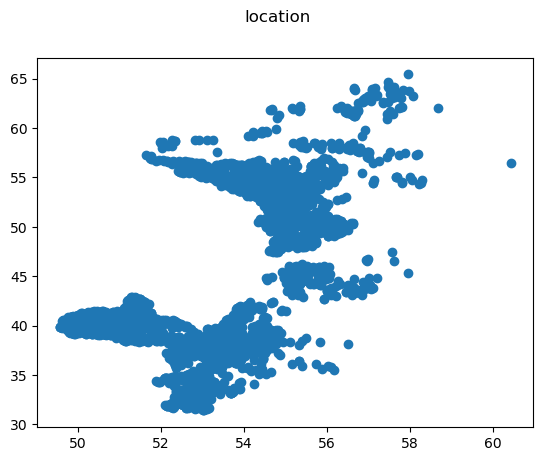

In [497]:
#visualize locations of the land plots:

import matplotlib.pyplot as plt

# Create some fake data.
x = df['.latit']
y = df['.long']
#x2 = df_test.iloc[2,5:]
#x3 = df_test.iloc[3,5:] 'latit', 'long'

fig, (ax1) = plt.subplots(1, 1)
fig.suptitle('location')

#ax1.plot(x1, '.')
#ax1.plot(x2, 'x')
#ax1.plot(x3, 'o')

plt.scatter(x, y)

ax1.set_ylabel('')


plt.show()


In [439]:
df1=add_cumulative(add_data(df1))
df_test=add_cumulative(add_data(df_test))

In [486]:
#adding samples which are wrogly classified
df1 = df#.reindex(sorted(df.columns), axis=1)
ind = []
for i in range(3):
    models, idx = diff_samples_add(df1)
    ind.append(idx)
    df1 = pd.concat([df1, df1.iloc[idx,:],df1.iloc[idx,:],df1.iloc[idx,:],df1.iloc[idx,:]], axis = 0, ignore_index = True)
df1

#results of redictions show better predictions for crop in [1,3,5] and much worse in [0,2,4,6]




C:\miniconda3\envs\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=41) 
 [0.94857143 1.         0.97826087 1.         0.95321637 1.
 0.93296089]


C:\miniconda3\envs\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=41) 
 [0.92682927 1.         0.98907104 1.         0.93908629 1.
 0.94267516]


C:\miniconda3\envs\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=41) 
 [0.93617021 1.         0.96551724 1.         0.9122807  1.
 0.95597484]


C:\miniconda3\envs\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=41) 
 [0.92462312 1.         0.98076923 1.         0.93854749 1.
 0.96491228]


C:\miniconda3\envs\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=41) 
 [0.97309417 1.         0.98130841 1.         1.         1.
 0.98461538]


C:\miniconda3\envs\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=41) 
 [0.98654709 0.99465241 1.         1.         0.99537037 1.
 0.96650718]


C:\miniconda3\envs\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=41) 
 [0.9874477  0.99450549 0.99009901 1.         0.99557522 1.
 0.98969072]


C:\miniconda3\envs\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=41) 
 [0.99141631 1.         0.99393939 1.         0.99591837 1.
 0.96078431]


C:\miniconda3\envs\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=41) 
 [0.99576271 0.99411765 1.         1.         1.         1.
 1.        ]


C:\miniconda3\envs\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=41) 
 [0.99561404 1.         1.         1.         0.97402597 0.99401198
 1.        ]


C:\miniconda3\envs\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=41) 
 [0.98       1.         1.         1.         1.         1.
 0.99065421]


C:\miniconda3\envs\Python\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingClassifier(max_iter=300, max_leaf_nodes=41) 
 [0.99615385 1.         0.98522167 1.         1.         1.
 0.98623853]


,.geo,.latit,.long,area,crop,id,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,...,nd_mean_2021-07-29,nd_mean_2021-07-31,nd_mean_2021-08-01,nd_mean_2021-08-07,nd_mean_2021-08-10,nd_mean_2021-08-11,nd_mean_2021-08-12,nd_mean_2021-08-13,nd_mean_2021-08-23,nd_mean_2021-08-27
0,"{""type"":""Polygon"",""coordinates"":[[[42.49107269...",51.412815,42.500303,20,3,3536,0.187150,0.072846,0.262300,0.261778,...,0.727516,0.000000,0.754859,0.000000,0.030883,0.000000,0.658016,0.126832,0.034858,0.614770
1,"{""type"":""Polygon"",""coordinates"":[[[50.25545110...",56.606045,50.265608,45,4,3739,0.245285,0.332928,0.349133,0.287182,...,0.666918,0.089721,0.706226,0.184231,0.062582,0.618475,0.601685,0.174914,0.000000,0.179612
2,"{""type"":""Polygon"",""coordinates"":[[[37.99698998...",53.837187,38.003231,28,2,1294,0.006391,0.013679,0.000000,0.007055,...,0.321827,0.411168,0.000000,0.357296,0.045370,0.172080,0.000000,0.090607,0.000000,0.054127
3,"{""type"":""Polygon"",""coordinates"":[[[44.72154181...",55.935536,44.727709,19,5,2859,0.293425,0.105976,0.318047,0.052500,...,0.000000,0.055983,0.152193,0.060656,0.352723,0.379196,0.327025,0.073492,0.061776,0.378900
4,"{""type"":""Polygon"",""coordinates"":[[[34.77829934...",52.907252,34.783534,33,4,3685,0.027983,0.130885,0.117227,0.063492,...,0.833694,0.611108,0.772962,0.000000,0.080592,0.000000,0.055220,0.157676,0.022251,0.012048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5677,"{""type"":""Polygon"",""coordinates"":[[[41.66286600...",53.873194,41.667172,11,2,3228,0.126039,0.216415,0.055117,0.000000,...,0.518057,0.648714,0.148789,0.238772,0.026477,0.044045,0.024325,0.057502,0.281476,0.008331
5678,"{""type"":""Polygon"",""coordinates"":[[[52.86918895...",55.519193,52.873871,20,6,5512,0.095430,0.057648,0.005054,0.265181,...,0.596380,0.124434,0.459071,0.000000,0.000000,0.020646,0.529615,0.074529,0.117315,0.170634
5679,"{""type"":""Polygon"",""coordinates"":[[[39.83557101...",52.417742,39.841980,86,0,4946,0.216283,0.148546,0.077047,0.202994,...,0.726082,0.755649,0.611095,0.591081,0.002152,0.000000,0.030503,0.000000,0.173605,0.106607
5680,"{""type"":""Polygon"",""coordinates"":[[[36.57005088...",52.386253,36.574536,16,6,2816,0.226987,0.000000,0.054660,0.061964,...,0.431980,0.806340,0.591332,0.077891,0.175456,0.120139,0.749090,0.016845,0.000000,0.000000


In [498]:
#remove 0 and replace with NaN as HGBC works better with NAns
df1 = filter_0_nan(df1) #
df_test = filter_0_nan(df_test)#

7
6


In [508]:
df1.columns

Index(['.geo', '.latit', '.long', 'area', 'crop', 'id', 'nd_mean_2021-04-15',
       'nd_mean_2021-04-16', 'nd_mean_2021-04-18', 'nd_mean_2021-04-19',
       'nd_mean_2021-04-20', 'nd_mean_2021-04-22', 'nd_mean_2021-04-23',
       'nd_mean_2021-04-25', 'nd_mean_2021-04-26', 'nd_mean_2021-04-27',
       'nd_mean_2021-04-28', 'nd_mean_2021-04-29', 'nd_mean_2021-04-30',
       'nd_mean_2021-05-01', 'nd_mean_2021-05-02', 'nd_mean_2021-05-03',
       'nd_mean_2021-05-04', 'nd_mean_2021-05-07', 'nd_mean_2021-05-08',
       'nd_mean_2021-05-09', 'nd_mean_2021-05-10', 'nd_mean_2021-05-15',
       'nd_mean_2021-05-16', 'nd_mean_2021-05-17', 'nd_mean_2021-05-19',
       'nd_mean_2021-05-20', 'nd_mean_2021-05-21', 'nd_mean_2021-05-24',
       'nd_mean_2021-05-26', 'nd_mean_2021-05-27', 'nd_mean_2021-05-29',
       'nd_mean_2021-06-02', 'nd_mean_2021-06-03', 'nd_mean_2021-06-04',
       'nd_mean_2021-06-05', 'nd_mean_2021-06-06', 'nd_mean_2021-06-07',
       'nd_mean_2021-06-09', 'nd_mean_2021-06-

In [509]:
X = df1.drop(['id','.geo',"crop", 'area'], axis = 1)#"id", '.long_full', '.latit_full', '7', 'index'
y = df1["crop"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [510]:
X_val = df_test.drop(['id','.geo', 'area'], axis = 1)#.drop(ddf.index,axis=0), 'crop'

In [514]:
X_val.shape

(2071, 72)

In [515]:
#train to predict good/bad class
clf0 = HistGradientBoostingClassifier(max_iter=200, max_leaf_nodes=45, random_state = 42, l2_regularization = 0.1, learning_rate = 0.1).fit(X_train, y_train)
clf = HistGradientBoostingClassifier(max_iter=200, max_leaf_nodes=41, random_state = 42, l2_regularization = 0.1).fit(X, y)
pred0 = clf0.predict(X_test)
pred2 = clf.predict(X_val)
print(clf0,'\n',recall_score(y_test, pred0, average=None, zero_division=0))
print(clf0,'\n',recall_score(y_test, pred0, average="macro", zero_division=0))

HistGradientBoostingClassifier(l2_regularization=0.1, max_iter=200,
                               max_leaf_nodes=45, random_state=42) 
 [1.         1.         1.         1.         0.9947644  1.
 0.98947368]
HistGradientBoostingClassifier(l2_regularization=0.1, max_iter=200,
                               max_leaf_nodes=45, random_state=42) 
 0.9977482974451836


In [517]:
df_test['crop'] = pred2
#df = pd.concat([df1

In [518]:
df_submission = pd.read_csv("sample_solution.csv")
df_submission.crop = pred2
df_submission.to_csv("submission.csv", index=False)